## Sandbox for Implementing RetinaNet

- start wih pretrined resnet50, maybe from the original paper, or mybe from fastai, doesn't really matter
- then add feature pyramid network and finetune for coco

## General Approach

1. Download CamVid
- Build and train U-Net
- Download COCO
- Build Feature Pyramid Network (FPN) with ResNet backbone
- Build and train RetinaNet with FPN and object detection subnets

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
from fastai.datasets import *
from fastai.callbacks import *
from fastai.utils.ipython import *

## CamVid

In [3]:
path = untar_data(URLs.CAMVID_TINY)
path_lbl = path/'labels'
path_img = path/'images'
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

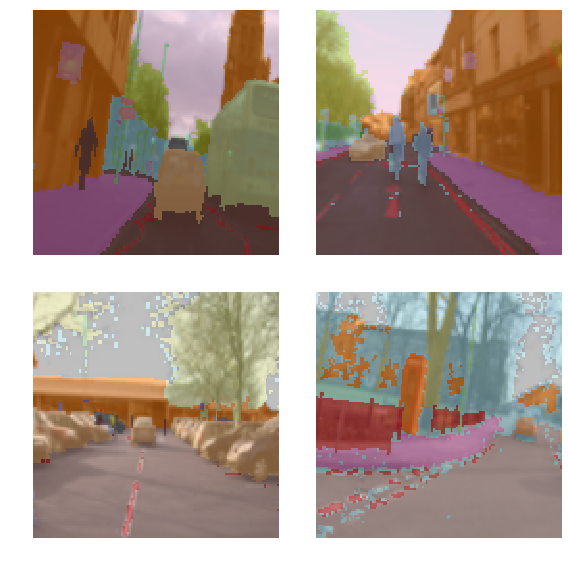

In [4]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'
tfms = get_transforms()
data = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct()
        .label_from_func(get_y_fn, classes=codes)
        .transform(tfms, tfm_y=True, size=128)
        .databunch(bs=64)
        .normalize(imagenet_stats))
data.show_batch(2)

## U-Net

In [5]:
class SaveMaps():
    """Save feature maps from contraction phase of unet after second convolution."""
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output): self.map = output
    def remove(self): self.hook.remove()

        
@dataclass
class SqueezeTarget(LearnerCallback):
    """Callback for adjusting target tensor shape for calculating cross entropy."""
    learn: Learner
    def on_batch_begin(self, **kwargs): 
        return {'last_target': kwargs['last_target'].squeeze(1)}
    
    
def iou(input, targs, classes):
    """Custom intersection-over-union metric for multi-class segmentation."""
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n, -1)
    targs = targs.contiguous().view(n, -1)
    inp = torch.stack([input==i for i in range(classes)]).cuda()
    tar = torch.stack([targs==i for i in range(classes)]).cuda()
    intersect = lambda a, b: (a*b).sum().float()
    union = lambda a, b: (a+b).sum().float()
    return torch.stack([intersect(a, b)/(union(a, b)-intersect(a, b)+1) for a, b in zip(inp, tar)]).mean()

In [6]:
def conv(ic, oc, k=3, s=1, p=0, actn=True):
    """Conv and optional activation."""
    layers = [nn.Conv2d(ic, oc, k, stride=s, padding=p)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers).cuda()


def conv_block(ic, oc, transpose=False, maxpool=True): 
    """Two conv block with optional conv transpose and maxpool modules."""
    layers = [conv(ic, oc, p=1), conv(oc, oc, p=1)]
    if transpose: layers.append(nn.ConvTranspose2d(oc, oc//2, 2, stride=2))
    if maxpool: layers.append(nn.MaxPool2d(2, stride=2))
    return nn.Sequential(*layers).cuda()


def unet_down(cs): 
    """Downward contraction pathway of UNet."""
    layers = [conv_block(cs[i], cs[i+1]) for i in range(len(cs)-2)]
    layers.append(conv_block(cs[-2], cs[-1], transpose=True, maxpool=False))
    return nn.Sequential(*layers).cuda()


def unet_up(cs, classes):
    """Upward expansion pathway of UNet."""
    cs.reverse()
    cs.pop()
    layers = [conv_block(cs[i], cs[i+1], transpose=True, maxpool=False) for i in range(len(cs)-2)]
    layers.append(conv_block(cs[-2], cs[-1], transpose=False, maxpool=False))
    return nn.ModuleList(layers)


class UNet(nn.Module):
    """UNet module with down path, up path, and cross connections using saved feature maps."""
    def __init__(self, channels, classes):
        super().__init__()
        self.unet_down = unet_down(channels)
        self.unet_up = unet_up(channels, classes)
        self.drop_conv = nn.Sequential(conv(channels[-1], classes, k=1, actn=False))
        self.maps = [SaveMaps(block[-2]) for block in children(self.unet_down)]
        self.maps.pop()
        self.maps.reverse()
        
    def forward(self, x): 
        """Concatenate features maps from corresponding convolution+relu outputs in up/down paths."""
        x = self.unet_down(x)
        for i, m in enumerate(self.unet_up):
            x = torch.cat([self.maps[i].map, x], dim=1)
            x = m(x)
        return self.drop_conv(x)
    
    def close(self): 
        for mp in self.maps: mp.remove()

In [7]:
channels = [3, 64, 128, 256, 512, 1024]
classes = len(data.classes)
model = UNet(channels, classes)

In [8]:
learn = Learner(data, 
                model, 
                metrics=[partial(iou, classes=classes)], 
                opt_func=partial(torch.optim.SGD, momentum=0.99),
                loss_func=F.cross_entropy,
                callback_fns=[SqueezeTarget])
learn.init(nn.init.kaiming_normal_)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


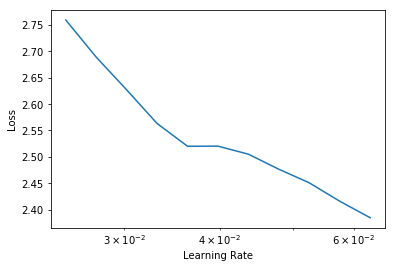

In [9]:
with gpu_mem_restore_ctx():  # prevent having to restart kernel for CUDA errors
    learn.lr_find(start_lr=1e-2, end_lr=100)
    learn.recorder.plot()

### Image Size: 256 & Batch Size: 32

In [10]:
callbacks = [
    ReduceLROnPlateauCallback(learn, patience=5, factor=0.5), 
    SaveModelCallback(learn, monitor='iou', mode='max', name='unet'), 
    TerminateOnNaNCallback(), 
    GradientClipping(learn, clip=0.1), 
    EarlyStoppingCallback(learn, min_delta=0.1, patience=20)]
learn.callbacks.extend(callbacks)
learn.fit_one_cycle(200, max_lr=1)

epoch,train_loss,valid_loss,iou,time
0,5.205150,5.063966,0.003619,00:01
1,5.185900,4.875054,0.003693,00:01
2,5.098692,4.607060,0.003854,00:01
3,4.985119,4.267471,0.004046,00:01
4,4.840959,3.874641,0.004673,00:01
5,4.678504,3.488807,0.010133,00:01
6,4.502812,3.214750,0.018829,00:01
7,4.333903,3.063912,0.021901,00:01
8,4.183969,2.982950,0.020014,00:01
9,4.052973,2.921136,0.018604,00:01


Better model found at epoch 0 with iou value: 0.0036194652784615755.
Better model found at epoch 1 with iou value: 0.0036927431356161833.
Better model found at epoch 2 with iou value: 0.003853818867355585.
Better model found at epoch 3 with iou value: 0.004045608453452587.
Better model found at epoch 4 with iou value: 0.0046732667833566666.
Better model found at epoch 5 with iou value: 0.010132690891623497.
Better model found at epoch 6 with iou value: 0.0188293419778347.
Better model found at epoch 7 with iou value: 0.02190122939646244.
Better model found at epoch 11 with iou value: 0.026439141482114792.
Better model found at epoch 12 with iou value: 0.035909730941057205.
Better model found at epoch 13 with iou value: 0.04011872410774231.
Better model found at epoch 16 with iou value: 0.041568122804164886.
Better model found at epoch 19 with iou value: 0.04158840700984001.
Better model found at epoch 20 with iou value: 0.04283452779054642.
Better model found at epoch 21 with iou value

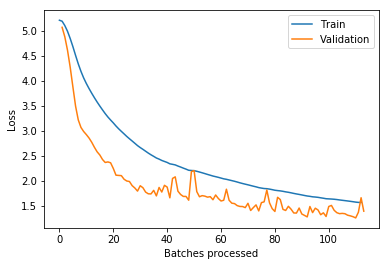

In [11]:
learn.recorder.plot_losses()

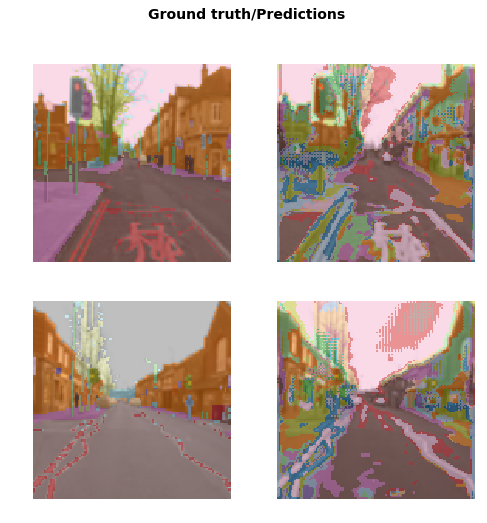

In [12]:
learn.show_results(rows=2)

### UNet Analysis on CamVid

## COCO